## Check List 3.1 - MultiICP Detector
* **3.1.1 MultiICP**  
  - initialize, set_config, get_config, get_image, detect, detect_and_register, disconnect  
  
  
* **TBD**
  - Auto initialization to estimate initial guess for ICP is not perfect
  - Robust and reliable initial guess for gloabl registration will be done
  - Multiple instance for the same class will be done

## Set running directory to Project source

In [1]:
import os
import sys
import numpy as np
import cv2
import copy
import matplotlib.pyplot as plt
os.chdir(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src'))

In [2]:
from pkg.global_config import RNB_PLANNING_DIR
from pkg.utils.utils import *    
from pkg.utils.rotation_utils import *
from pkg.controller.combined_robot import *
from pkg.geometry.builder.scene_builder import SceneBuilder
from pkg.geometry.geometry import GeometryItem
from pkg.geometry.geotype import GEOTYPE
from pkg.detector.detector_interface import DetectionLevel
from pkg.detector.multiICP.config import *

In [3]:
# add camera geometry
def add_cam(gscene, tool_link="indy0_tcp"):
    gscene.create_safe(gtype=GEOTYPE.CYLINDER, name="cam", link_name=tool_link,
                       dims=(0.061, 0.061, 0.026), center=(-0.0785, 0, 0.013), rpy=(0, 0, 0),
                       color=(0.8, 0.8, 0.8, 0.5), display=True, fixed=True, collision=False)

    gscene.create_safe(gtype=GEOTYPE.CYLINDER, name="cam_col", link_name=tool_link,
                       dims=(0.081, 0.081, 0.046), center=(-0.0785, 0, 0.013), rpy=(0, 0, 0),
                       color=(0.8, 0.8, 0.8, 0.2), display=True, fixed=True, collision=True)

    viewpoint = gscene.create_safe(gtype=GEOTYPE.SPHERE, name="viewpoint", link_name=tool_link,
                                   dims=(0.01, 0.01, 0.01), center=(-0.013, 0, 0), rpy=(0, 0, -np.pi / 2),
                                   color=(1, 0, 0, 0.3), display=True, fixed=True, collision=False, parent="cam")

    gscene.create_safe(gtype=GEOTYPE.CYLINDER, name="body", link_name=tool_link,
                       dims=(0.067, 0.067, 0.0335), center=(-0.0785, 0, -0.01675), rpy=(0, 0, 0),
                       color=(0.8, 0.8, 0.8, 1), display=True, fixed=True, collision=False)

    gscene.create_safe(gtype=GEOTYPE.CYLINDER, name="body_col", link_name=tool_link,
                       dims=(0.087, 0.087, 0.0535), center=(-0.0785, 0, -0.01675), rpy=(0, 0, 0),
                       color=(0.8, 0.8, 0.8, 0.2), display=True, fixed=True, collision=True)

    gscene.create_safe(gtype=GEOTYPE.SPHERE, name="backhead", link_name=tool_link,
                       dims=(0.067, 0.067, 0.067), center=(-0.0785, 0, -0.0335), rpy=(0, 0, 0),
                       color=(0.8, 0.8, 0.8, 1), display=True, fixed=True, collision=False)

    gscene.create_safe(gtype=GEOTYPE.SPHERE, name="backhead_col", link_name=tool_link,
                       dims=(0.087, 0.087, 0.087), center=(-0.0785, 0, -0.0335), rpy=(0, 0, 0),
                       color=(0.8, 0.8, 0.8, 0.2), display=True, fixed=True, collision=True)
    return viewpoint

### 3.1.1 MultiICP

In [4]:
from pkg.detector.multiICP.multiICP import MultiICP, MultiICP_Obj
from pkg.detector.camera.realsense import RealSense
from pkg.detector.detector_interface import DetectionLevel

##### create multiICP instance

In [5]:
micp = MultiICP(RealSense())

##### initialize()

In [6]:
micp.initialize()

Start streaming
Initialize Done


##### create SceneBuilder instance and geometry scene

In [ ]:
INDY_BASE_OFFSET = (0.172,0,0.439)
INDY_BASE_RPY = (0,0,0)
mobile_config = RobotConfig(0, RobotType.kmb, ((0,0,0), (0,0,0)),
                "{}/{}".format(None, None))
robot_config = RobotConfig(1, RobotType.indy7, 
                           (INDY_BASE_OFFSET, INDY_BASE_RPY),
                           None, root_on="kmb0_platform", 
                           specs={"no_sdk":True})
MOBILE_NAME = mobile_config.get_indexed_name()
ROBOT_NAME = robot_config.get_indexed_name()
crob = CombinedRobot(robots_on_scene=[mobile_config, robot_config]
              , connection_list=[False, False])

scene_builder = SceneBuilder.instance(detector=micp)
gscene = scene_builder.create_gscene(crob)

from pkg.planning.scene import PlanningScene
pscene = PlanningScene(gscene, combined_robot=crob)

ROBOT_BASE = pscene.robot_chain_dict[ROBOT_NAME]['link_names'][0]
TIP_LINK = pscene.robot_chain_dict[ROBOT_NAME]["tip_link"]
MOBILE_BASE = pscene.robot_chain_dict[MOBILE_NAME]["tip_link"]
HOLD_LINK = MOBILE_BASE

viewpoint = add_cam(gscene, tool_link=TIP_LINK)
VIEW_POSE = np.deg2rad([  0., 50.,  -70.,  -0.,  -90., 0])
VIEW_LOC = [0]*6
VIEW_POSE_EXT = np.array(VIEW_LOC + list(VIEW_POSE))
T_bc = viewpoint.get_tf(VIEW_POSE_EXT)
T_cb = SE3_inv(T_bc)
gscene.show_pose(VIEW_POSE_EXT)

### Set MultiICP configs
* You have to make micp, hrule and grule for each object you want to detect

* hrule means heuristic rule for special object which cannot be detected thorugh mask rcnn using COCO dataset

* grule means initial guess(R,t) for ICP

* Run shraed detector to detect object in color image

##### Run shared detector for object detection on bash
```bash
python3 /home/jhkim/Projects/rnb-planning/src/pkg/detector/multiICP/shared_detector.py --dims='(720,1280,3)'
```

#### Clearing shared detector channels if zombie memory remains
```python
from pkg.utils.shared_function import clear_channels_on, sa
clear_channels_on("SharedDetector")
```

In [7]:
from pkg.utils.shared_function import clear_channels_on, sa
clear_channels_on("SharedDetector")

from pkg.detector.multiICP.shared_detector import SharedDetectorGen
sd = SharedDetectorGen(micp.img_dim+(3,))()
sd.init()

RuntimeError: [ERROR] executing function call init.shareddetector
name 'init_detector' is not defined 

##### Load example data (for bed, closet)
* You need to prepare example data and stl model to test MultiICP detector 
* Use color image, depth image and csv file which has joint values Q with cam_intrins, depth_scale 
* file path: release/multiICP_data/

In [9]:
def load_rdict(file_name, intrins, depth_scale):
    rdict = {}
    
    rdict['color'] = cv2.imread(
        os.path.join('../release/multiICP_data/', file_name + '.jpg'), flags=cv2.IMREAD_UNCHANGED)
    rdict['depth'] = cv2.imread(
        os.path.join('../release/multiICP_data/', file_name + '.png'), flags=cv2.IMREAD_UNCHANGED)
    
    rdict['intrins'], rdict['depth_scale'] = intrins, depth_scale
    
    Q = np.loadtxt(os.path.join('../release/multiICP_data/', file_name + '.csv'), delimiter=",")
    return rdict, np.array(Q)


cam_intrins = [1280, 720,
               909.957763671875, 909.90283203125,
               638.3824462890625, 380.0085144042969]
depth_scale = 1 / 3999.999810010204

rdict, Qtest = load_rdict("test_1", cam_intrins, depth_scale)
color_img = rdict['color']
depth_img = rdict['depth']
Tc = viewpoint.get_tf(Qtest)
gscene.show_pose(Qtest)

In [10]:
T_cb = SE3_inv(Tc)

In [9]:
obj_info_dict = get_obj_info()

In [12]:
# object items you want to detect
# heuristic rule items, Initial guess rule items
micp_bed = MultiICP_Obj(obj_info_dict["bed"], None,
                        OffsetOnModelCoord("bed", R=np.matmul(T_cb[:3, :3], Rot_axis(3, np.pi)),
                                          offset=np.matmul(T_cb[:3, :3], (1.1 * 0.5, 0, -0.5))))

mrule_closet = MaskBoxRule("closet", "bed", merge_rule=np.all)
mrule_closet.update_rule = ClosetRuleFun(mrule_closet)
micp_closet = MultiICP_Obj(obj_info_dict["closet"], 
                           mrule_closet,
                           OffsetOnModelCoord("closet", 
                                             offset=(0, 1, 0.3),
                                             use_median=True
                                     ))

In [13]:
micp_dict = {"bed": micp_bed, "closet": micp_closet}

In [11]:
micp.set_config(micp_dict, sd, crob, viewpoint)

##### get_config()
* This should return camera matrix (3x3), distortion coefficients (4, 5, or 8 element vector) and depth scale.
* Depth scale is scale value of depth image

In [12]:
camera_matrix, dist_coeffs, depth_scale = micp.get_camera_config()
print("camera_matrix: {} \n {}".format(camera_matrix.shape, camera_matrix))
print("dist_coeffs: {} \n {}".format(dist_coeffs.shape, dist_coeffs))
print("depth_scale:  \n {}".format(depth_scale))

camera_matrix: (3, 3) 
 [[899.05322266   0.         654.88366699]
 [  0.         899.21044922 352.92956543]
 [  0.           0.           1.        ]]
dist_coeffs: (5,) 
 [ 0.15870179 -0.46903715 -0.0014261   0.00066797  0.41631824]
depth_scale:  
 0.000250000011874


##### get_image()
* This will return camera image (RGB order), depth image and joint values

Joint values:  
 [ 0.          0.          0.          0.          0.          0.
  0.          0.         -1.57079633  0.         -1.57079633  0.        ]


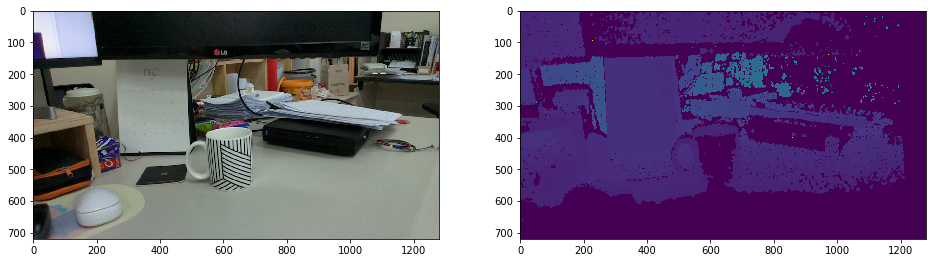

In [13]:
color_image, depth_image, Q = micp.get_image()
print("Joint values:  \n {}".format(Q))
plt.figure(figsize=(16,9))
plt.subplot(121)
plt.imshow(color_image[:,:,[2,1,0]]) # Transpose in the last dimension is for RGB-to-BGR conversion. (plt.imshow shows image in BGR order)
plt.subplot(122)
plt.imshow(depth_image)

##### detect()
* Object Detection through swin-transformer based mask rcnn using mmdet
* To use test data(color, depth image and joint value Q), you have to call cache_sensor()
* Detection result is the transformation w.r.t base coord

In [17]:
micp.cache_sensor(color_img, depth_img, Qtest,
                  cam_intrins, depth_scale)

In [13]:
pose_dict = micp.detect(visualize=True)

name_mask is None
===== Detected : person, 2 object(s) =====
===== Detected : bottle, 1 object(s) =====
===== Detected : cup, 3 object(s) =====
===== Detected : tv, 4 object(s) =====
===== Detected : mouse, 2 object(s) =====
===== Detected : remote, 1 object(s) =====
===== Detected : keyboard, 1 object(s) =====
===== Detected : cell phone, 2 object(s) =====
===== Detected : book, 25 object(s) =====

'cup' is not in gscene. Use manual input for initial guess

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.333283e-02, and correspondence_set size of 740
Access transformation to get result.
Transformation is:
[[ 0.75296317  0.63115238 -0.18626092 -0.15464646]
 [-0.29115585  0.06568761 -0.95441784  0.18588603]
 [-0.59014806  0.77287244  0.23322406  0.97877132]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=8.747206e-03, and correspondence_

##### reset_reference_coord()
* **WARNING** MultiICP need pre-initialized CombinedRobot and GeometryScene: Should not call reset_reference_coord

##### detect_and_register()
* Detect items in the field of view and register them to the GeometryScene
* They will appear in the RVIZ



In [ ]:
micp.cache_sensor(color_img, depth_img, Qtest,
                  cam_intrins, depth_scale)

In [18]:
gtem_dict = scene_builder.detect_and_register(level_mask=[DetectionLevel.ENVIRONMENT])
# gtem_dict = scene_builder.detect_and_register(level_mask=[DetectionLevel.MOVABLE])

name_mask is ['cup']
===== Detected : cup, 1 object(s) =====

'cup' is not in gscene. Use manual input for initial guess

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.596477e-02, and correspondence_set size of 2377
Access transformation to get result.
Transformation is:
[[ 0.99101407  0.12513531  0.04724678 -0.10694832]
 [-0.03638971  0.59213602 -0.80501598 -0.00342604]
 [-0.12871245  0.79606287  0.59136877  0.50118494]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.574430e-02, and correspondence_set size of 1190
Access transformation to get result.
Transformation is:
[[ 0.98895127  0.09973031  0.10967798 -0.10698201]
 [ 0.02907208  0.59501614 -0.80318777 -0.00783688]
 [-0.14536233  0.79750213  0.5855426   0.50182474]
 [ 0.          0.          0.          1.        ]]
Found 6DoF pose of cup
[WARN] Vertices for mesh should be have

##### disconnect()

In [19]:
micp.disconnect()

* MultiICP 클래스 분리 <- obj_info, hrule, grule  V
* 총괄 set_config에서 obj_info_dict 병합  V
* sd, gscene, crob 클래스 멤버로  V
* detect() 프로토타입 맞추기  V -> 클래스 당 물체 하나로ㅖ
* SceneBuilder와 연동  V -> scene에 나타나는 위치 이상
* 예제 데이터와 설명 추가
* Combined 파일에 micp_cup 추가 -> 통합 인식 확인

```python
Tc = (viewpoint.get_tf(Q)) or np.matmul(gscene.get_tf(link_name, Q), Toff)
```